In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.utils import nodes_or_number, py_random_state
import seaborn as sns

In [2]:
from operator import itemgetter
import random
import itertools
from bisect import bisect_left
from itertools import combinations
from itertools import product
from math import sqrt
import math

In [3]:
def estimar_distancia_media(G: nx.Graph, k: int=400) -> float:
    convinaciones = list(itertools.combinations(G.nodes,2))
    assert len(convinaciones) > k
    muestra = random.choices(convinaciones,k=k)
    distancias = [nx.shortest_path_length(G, cola, punta) for cola,punta in muestra]
    media = np.mean(distancias)
    stdev = np.std(distancias)
    return media, stdev

## Hierarchical network model

In [27]:
?nx.powerlaw_cluster_graph

Signature: nx.powerlaw_cluster_graph(n, m, p, seed=None)
Docstring:
Holme and Kim algorithm for growing graphs with powerlaw
degree distribution and approximate average clustering.

Parameters
----------
n : int
    the number of nodes
m : int
    the number of random edges to add for each new node
p : float,
    Probability of adding a triangle after adding a random edge
seed : integer, random_state, or None (default)
    Indicator of random number generation state.
    See :ref:`Randomness<randomness>`.

Notes
-----
The average clustering has a hard time getting above a certain
cutoff that depends on `m`.  This cutoff is often quite low.  The
transitivity (fraction of triangles to possible triangles) seems to
decrease with network size.

It is essentially the Barabási–Albert (BA) growth model with an
extra step that each random edge is followed by a chance of
making an edge to one of its neighbors too (and thus a triangle).

This algorithm improves on BA in the sense that it enables 

## Powerlaw cluster graph

- Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering.

- The average clustering has a hard time getting above a certain cutoff that depends on `m`.  This cutoff is often quite low.  The transitivity (fraction of triangles to possible triangles) seems to decrease with network size.

- It is essentially the Barabási–Albert (BA) growth model with an extra step that each random edge is followed by a chance of making an edge to one of its neighbors too (and thus a triangle).

- This algorithm improves on BA in the sense that it enables a higher average clustering to be attained if desired.

- It seems possible to have a disconnected graph with this algorithm since the initial `m` nodes may not be all linked to a new node on the first iteration like the BA model.

Parameters
----------
- n : int
    - the number of nodes
- m : int
    - the number of random edges to add for each new node
- p : float,
    - Probability of adding a triangle after adding a random edge
- seed : integer, random_state, or None (default)
    - Indicator of random number generation state.

In [4]:
def _random_subset(seq, m, rng):
    """ Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [5]:
@py_random_state(3)
def powerlaw_clsuter_graph(n: int, m: int, p: float, seed = None) -> nx.Graph:
    G = nx.empty_graph(m)  # add m initial nodes (m0 in barabasi-speak)
    repeated_nodes = list(G.nodes())  # list of existing nodes to sample from
    # with nodes repeated once for each adjacent edge
    source = m               # next node is m
    while source < n:        # Now add the other n-1 nodes
        possible_targets = _random_subset(repeated_nodes, m, seed)
        # do one preferential attachment for new node
        target = possible_targets.pop()
        G.add_edge(source, target)
        repeated_nodes.append(target)  # add one node to list for each new link
        count = 1
        while count < m:  # add m-1 more new links
            if seed.random() < p:  # clustering step: add triangle
                neighborhood = [nbr for nbr in G.neighbors(target)
                                if not G.has_edge(source, nbr)
                                and not nbr == source]
                if neighborhood:  # if there is a neighbor without a link
                    nbr = seed.choice(neighborhood)
                    G.add_edge(source, nbr)  # add triangle
                    repeated_nodes.append(nbr)
                    count = count + 1
                    continue  # go to top of while loop
            # else do preferential attachment step if above fails
            target = possible_targets.pop()
            G.add_edge(source, target)
            repeated_nodes.append(target)
            count = count + 1

        repeated_nodes.extend([source] * m)  # add source node to list m times
        source += 1
    return G

In [6]:
G = nx.powerlaw_cluster_graph(5000, 3, .2)

/home/ackerman/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


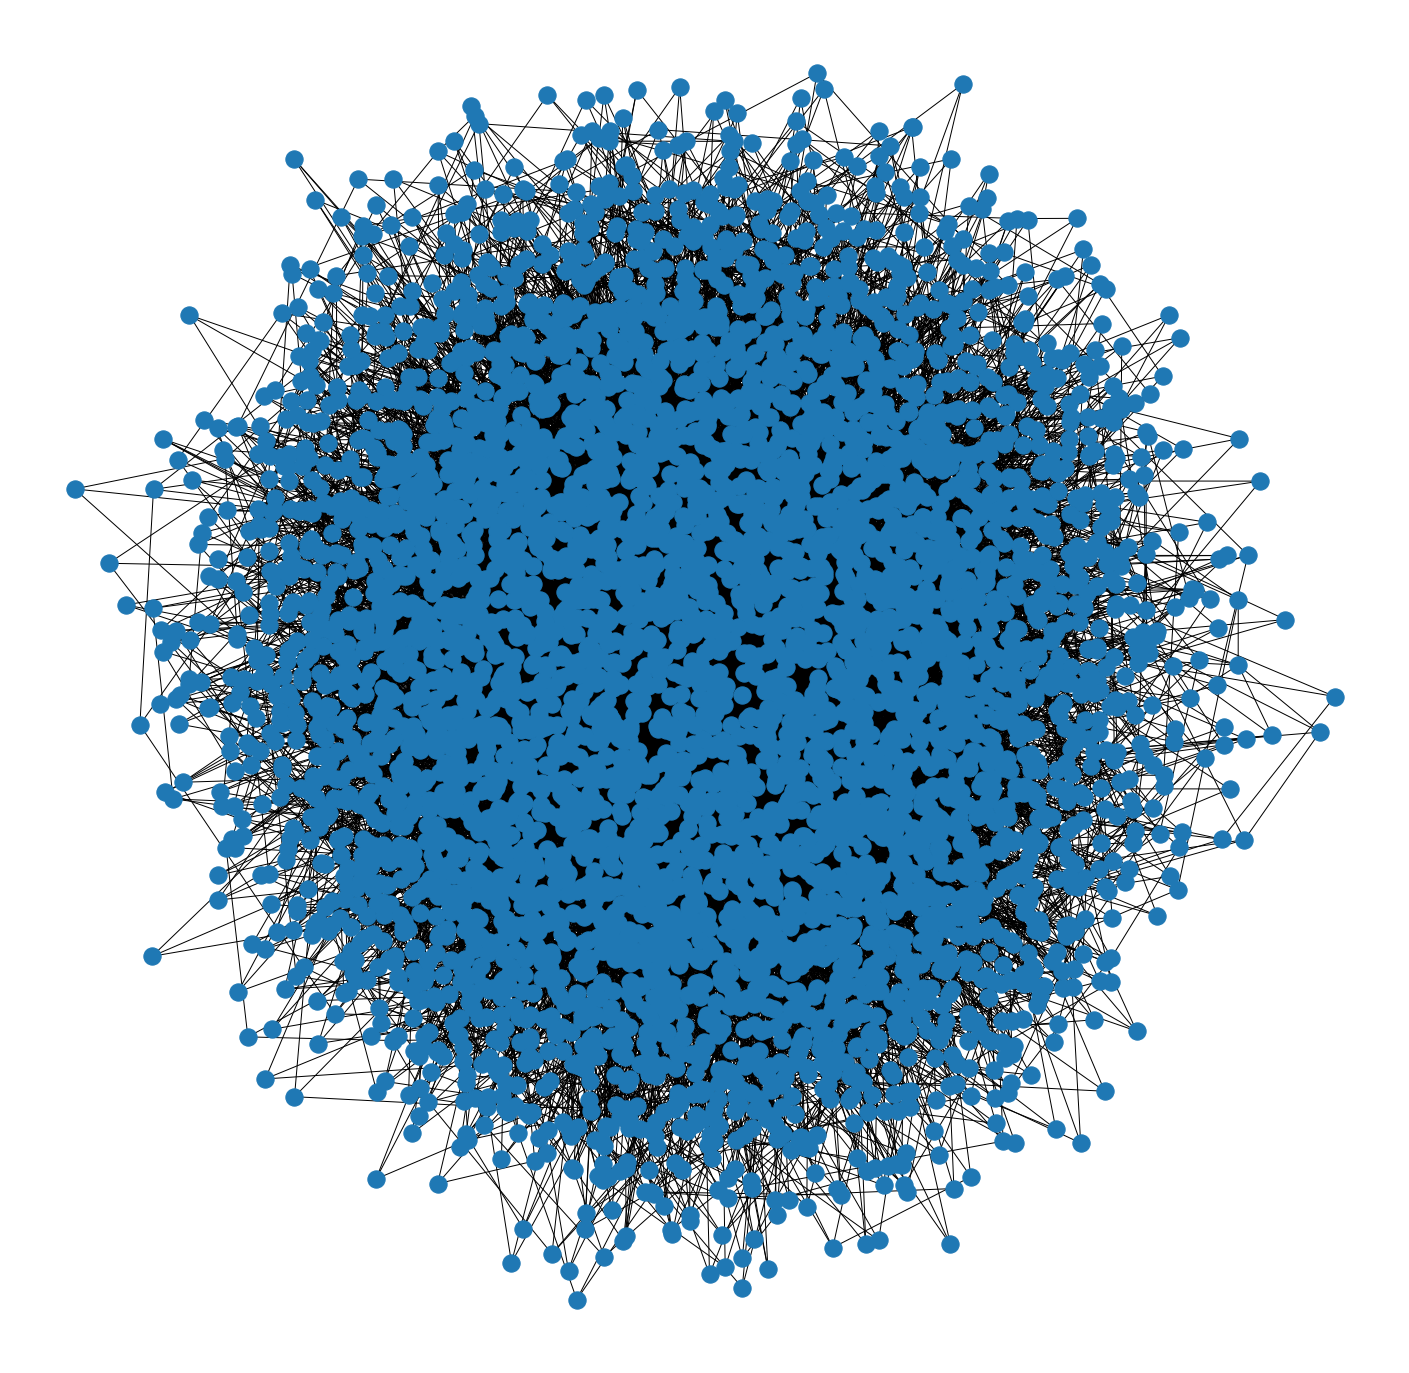

In [7]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

In [8]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Convenxo: ")
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 5000
 EDGES:  14989
 Convenxo: 
 Coeficiente de agrupamiento:  0.11451982277010804
 Distancia media:  4.0925
 Desviación estandar:  0.7608835324804973


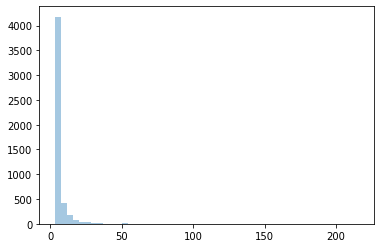

In [9]:
sns.distplot(list(dict(G.degree()).values()), kde=False)

# Uniform-Preferential-Attachment model (UPA model)

# Dual_barabasi_albert_graph

- Returns a random graph according to the dual Barabási–Albert preferential attachment model.

- A graph of $n$ nodes is grown by attaching new nodes each with either $m_1$ edges (with probability $p$) or $m_2$ edges (with probability $1-p$) that are preferentially attached to existing nodes with high degree

Parameters
----------
- n : int
    - Number of nodes
- m1 : int
    - Number of edges to attach from a new node to existing nodes with probability $p$
- m2 : int
    - Number of edges to attach from a new node to existing nodes with probability $1-p$
- p : float
    - The probability of attaching $m_1$ edges (as opposed to $m_2$ edges)
- seed : integer, random_state, or None (default)
    - Indicator of random number generation state.

In [10]:
?nx.dual_barabasi_albert_graph

Signature: nx.dual_barabasi_albert_graph(n, m1, m2, p, seed=None)
Docstring:
Returns a random graph according to the dual Barabási–Albert preferential
attachment model.

A graph of $n$ nodes is grown by attaching new nodes each with either $m_1$
edges (with probability $p$) or $m_2$ edges (with probability $1-p$) that
are preferentially attached to existing nodes with high degree.

Parameters
----------
n : int
    Number of nodes
m1 : int
    Number of edges to attach from a new node to existing nodes with probability $p$
m2 : int
    Number of edges to attach from a new node to existing nodes with probability $1-p$
p : float
    The probability of attaching $m_1$ edges (as opposed to $m_2$ edges)
seed : integer, random_state, or None (default)
    Indicator of random number generation state.
    See :ref:`Randomness<randomness>`.

Returns
-------
G : Graph

Raises
------
NetworkXError
    If `m1` and `m2` do not satisfy ``1 <= m1,m2 < n`` or `p` does not satisfy ``0 <= p <= 1``.

Ref

In [11]:
@py_random_state(2)
def barabasi_albert_graph(n, m, seed=None):
    """Returns a random graph according to the Barabási–Albert preferential
    attachment model.

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))

    # Add m initial nodes (m0 in barabasi-speak)
    G = empty_graph(m)
    # Target nodes for new edges
    targets = list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = []
    # Start adding the other n-m nodes. The first node is m.
    source = m
    while source < n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        source += 1
    return G

In [12]:
@py_random_state(4)
def dual_barabasi_albert_graph(n, m1, m2, p, seed=None):
    """Returns a random graph according to the dual Barabási–Albert preferential
    attachment model.

    A graph of $n$ nodes is grown by attaching new nodes each with either $m_1$
    edges (with probability $p$) or $m_2$ edges (with probability $1-p$) that
    are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m1 : int
        Number of edges to attach from a new node to existing nodes with probability $p$
    m2 : int
        Number of edges to attach from a new node to existing nodes with probability $1-p$
    p : float
        The probability of attaching $m_1$ edges (as opposed to $m_2$ edges)
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m1` and `m2` do not satisfy ``1 <= m1,m2 < n`` or `p` does not satisfy ``0 <= p <= 1``.

    References
    ----------
    .. [1] N. Moshiri "The dual-Barabasi-Albert model", arXiv:1810.10538.
    """

    if m1 < 1 or m1 >= n:
        raise nx.NetworkXError("Dual Barabási–Albert network must have m1 >= 1"
                               " and m1 < n, m1 = %d, n = %d" % (m1, n))
    if m2 < 1 or m2 >= n:
        raise nx.NetworkXError("Dual Barabási–Albert network must have m2 >= 1"
                               " and m2 < n, m2 = %d, n = %d" % (m2, n))
    if p < 0 or p > 1:
        raise nx.NetworkXError("Dual Barabási–Albert network must have 0 <= p <= 1,"
                               "p = %f" % p)
    
    # For simplicity, if p == 0 or 1, just return BA
    if p == 1:
        return barabasi_albert_graph(n, m1, seed)
    elif p == 0:
        return barabasi_albert_graph(n, m2, seed)

    # Add max(m1,m2) initial nodes (m0 in barabasi-speak)
    G = empty_graph(max(m1,m2))
    # Target nodes for new edges
    targets = list(range(max(m1,m2)))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = []
    # Start adding the remaining nodes.
    source = max(m1,m2)
    # Pick which m to use first time (m1 or m2)
    if seed.random() < p:
        m = m1
    else:
        m = m2
    while source < n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)
        # Pick which m to use next time (m1 or m2)
        if seed.random() < p:
            m = m1
        else:
            m = m2
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        source += 1
    return G

In [13]:
G = nx.dual_barabasi_albert_graph(5000, 50, 20, .3)

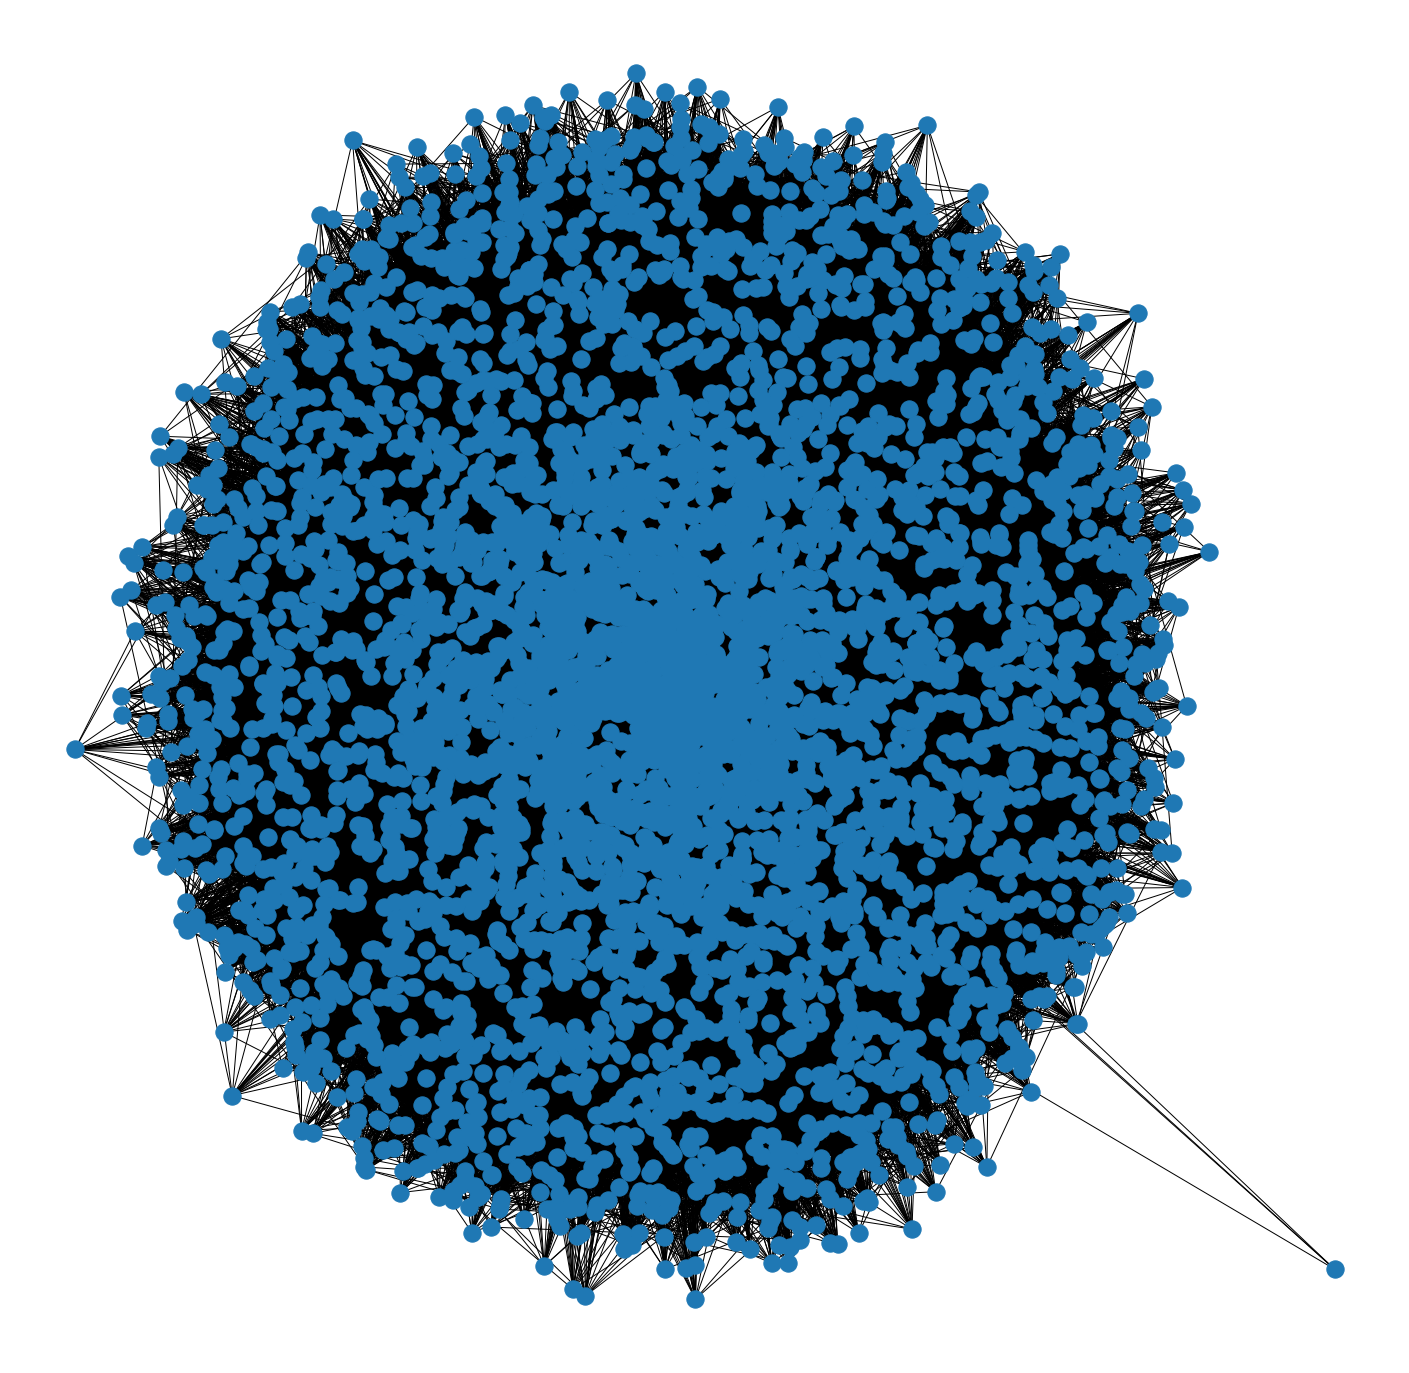

In [14]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

In [15]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Convenxo: ")
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 5000
 EDGES:  143700
 Convenxo: 
 Coeficiente de agrupamiento:  0.04705391110525476
 Distancia media:  2.4525
 Desviación estandar:  0.5364175146282977


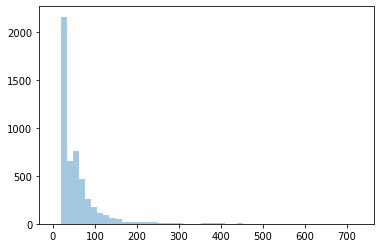

In [16]:
sns.distplot(list(dict(G.degree()).values()), kde=False)

## Extended barabasi albert graph

- Returns an extended Barabási–Albert model graph.

- An extended Barabási–Albert model graph is a random graph constructed using preferential attachment. The extended model allows new edges, rewired edges or new nodes. Based on the probabilities $p$ and $q$ with $p + q < 1$, the growing behavior of the graph is determined as:

- 1) With $p$ probability, $m$ new edges are added to the graph, starting from randomly chosen existing nodes and attached preferentially at the other end.

- 2) With $q$ probability, $m$ existing edges are rewired by randomly choosing an edge and rewiring one end to a preferentially chosen node.

- 3) With $(1 - p - q)$ probability, $m$ new nodes are added to the graph with edges attached preferentially.

- When $p = q = 0$, the model behaves just like the Barabási–Alber model

- n : int
    - Number of nodes
- m : int
    - Number of edges with which a new node attaches to existing nodes
- p : float
    - Probability value for adding an edge between existing nodes. p + q < 1
- q : float
    - Probability value of rewiring of existing edges. p + q < 1
- seed : integer, random_state, or None (default)
    - Indicator of random number generation state.

In [4]:
@py_random_state(4)
def extended_barabasi_albert_graph(n, m, p, q, seed=None):
    """Returns an extended Barabási–Albert model graph.

    An extended Barabási–Albert model graph is a random graph constructed
    using preferential attachment. The extended model allows new edges,
    rewired edges or new nodes. Based on the probabilities $p$ and $q$
    with $p + q < 1$, the growing behavior of the graph is determined as:

    1) With $p$ probability, $m$ new edges are added to the graph,
    starting from randomly chosen existing nodes and attached preferentially at the other end.

    2) With $q$ probability, $m$ existing edges are rewired
    by randomly choosing an edge and rewiring one end to a preferentially chosen node.

    3) With $(1 - p - q)$ probability, $m$ new nodes are added to the graph
    with edges attached preferentially.

    When $p = q = 0$, the model behaves just like the Barabási–Alber mo

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges with which a new node attaches to existing nodes
    p : float
        Probability value for adding an edge between existing nodes. p + q < 1
    q : float
        Probability value of rewiring of existing edges. p + q < 1
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n`` or ``1 >= p + q``

    References
    ----------
    .. [1] Albert, R., & Barabási, A. L. (2000)
       Topology of evolving networks: local events and universality
       Physical review letters, 85(24), 5234.
    """
    if m < 1 or m >= n:
        msg = "Extended Barabasi-Albert network needs m>=1 and m<n, m=%d, n=%d"
        raise nx.NetworkXError(msg % (m, n))
    if p + q >= 1:
        msg = "Extended Barabasi-Albert network needs p + q <= 1, p=%d, q=%d"
        raise nx.NetworkXError(msg % (p, q))

    # Add m initial nodes (m0 in barabasi-speak)
    G = empty_graph(m)

    # List of nodes to represent the preferential attachment random selection.
    # At the creation of the graph, all nodes are added to the list
    # so that even nodes that are not connected have a chance to get selected,
    # for rewiring and adding of edges.
    # With each new edge, nodes at the ends of the edge are added to the list.
    attachment_preference = []
    attachment_preference.extend(range(m))

    # Start adding the other n-m nodes. The first node is m.
    new_node = m
    while new_node < n:
        a_probability = seed.random()

        # Total number of edges of a Clique of all the nodes
        clique_degree = len(G) - 1
        clique_size = (len(G) * clique_degree) / 2

        # Adding m new edges, if there is room to add them
        if a_probability < p and G.size() <= clique_size - m:
            # Select the nodes where an edge can be added
            elligible_nodes = [nd for nd, deg in G.degree()
                               if deg < clique_degree]
            for i in range(m):
                # Choosing a random source node from elligible_nodes
                src_node = seed.choice(elligible_nodes)

                # Picking a possible node that is not 'src_node' or
                # neighbor with 'src_node', with preferential attachment
                prohibited_nodes = list(G[src_node])
                prohibited_nodes.append(src_node)
                # This will raise an exception if the sequence is empty
                dest_node = seed.choice([nd for nd in attachment_preference
                                           if nd not in prohibited_nodes])
                # Adding the new edge
                G.add_edge(src_node, dest_node)

                # Appending both nodes to add to their preferential attachment
                attachment_preference.append(src_node)
                attachment_preference.append(dest_node)

                # Adjusting the elligible nodes. Degree may be saturated.
                if G.degree(src_node) == clique_degree:
                    elligible_nodes.remove(src_node)
                if G.degree(dest_node) == clique_degree \
                        and dest_node in elligible_nodes:
                    elligible_nodes.remove(dest_node)

        # Rewiring m edges, if there are enough edges
        elif p <= a_probability < (p + q) and m <= G.size() < clique_size:
            # Selecting nodes that have at least 1 edge but that are not
            # fully connected to ALL other nodes (center of star).
            # These nodes are the pivot nodes of the edges to rewire
            elligible_nodes = [nd for nd, deg in G.degree()
                               if 0 < deg < clique_degree]
            for i in range(m):
                # Choosing a random source node
                node = seed.choice(elligible_nodes)

                # The available nodes do have a neighbor at least.
                neighbor_nodes = list(G[node])

                # Choosing the other end that will get dettached
                src_node = seed.choice(neighbor_nodes)

                # Picking a target node that is not 'node' or
                # neighbor with 'node', with preferential attachment
                neighbor_nodes.append(node)
                dest_node = seed.choice([nd for nd in attachment_preference
                                           if nd not in neighbor_nodes])
                # Rewire
                G.remove_edge(node, src_node)
                G.add_edge(node, dest_node)

                # Adjusting the preferential attachment list
                attachment_preference.remove(src_node)
                attachment_preference.append(dest_node)

                # Adjusting the elligible nodes.
                # nodes may be saturated or isolated.
                if G.degree(src_node) == 0 and src_node in elligible_nodes:
                    elligible_nodes.remove(src_node)
                if dest_node in elligible_nodes:
                    if G.degree(dest_node) == clique_degree:
                        elligible_nodes.remove(dest_node)
                else:
                    if G.degree(dest_node) == 1:
                        elligible_nodes.append(dest_node)

        # Adding new node with m edges
        else:
            # Select the edges' nodes by preferential attachment
            targets = _random_subset(attachment_preference, m, seed)
            G.add_edges_from(zip([new_node] * m, targets))

            # Add one node to the list for each new edge just created.
            attachment_preference.extend(targets)
            # The new node has m edges to it, plus itself: m + 1
            attachment_preference.extend([new_node] * (m + 1))
            new_node += 1
    return G

In [ ]:
G = nx.extended_barabasi_albert_graph(4000, 2, .5, .3)

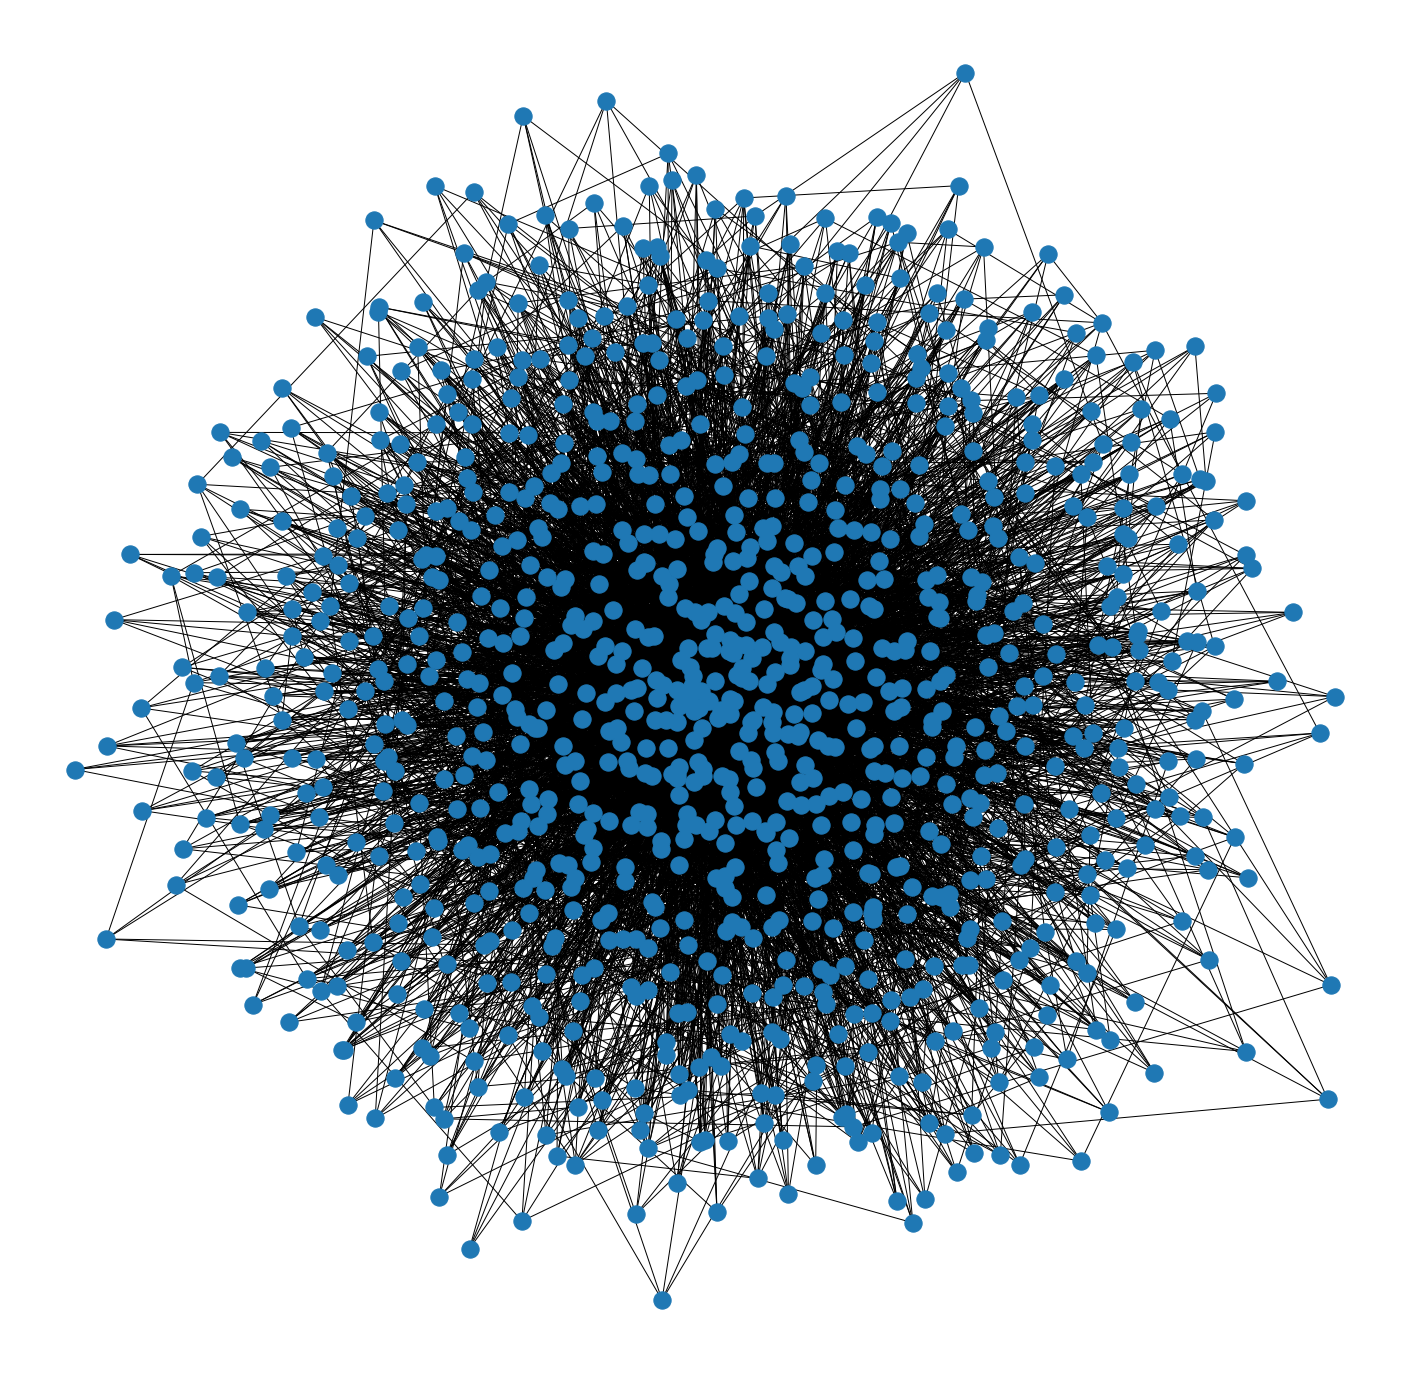

In [22]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

In [23]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Convenxo: ")
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 1000
 EDGES:  9710
 Convenxo: 
 Coeficiente de agrupamiento:  0.11437657097514967
 Distancia media:  2.5525
 Desviación estandar:  0.5312661762243104


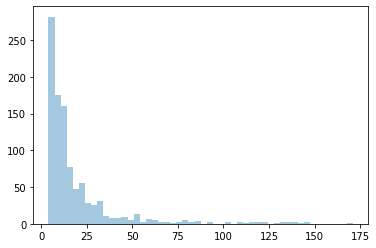

In [24]:
sns.distplot(list(dict(G.degree()).values()), kde=False)

# Hyperbolic geometric graphs

In [62]:
?nx.soft_random_geometric_graph

Signature:
nx.soft_random_geometric_graph(
    n,
    radius,
    dim=2,
    pos=None,
    p=2,
    p_dist=None,
    seed=None,
)
Docstring:
Returns a soft random geometric graph in the unit cube.

The soft random geometric graph [1] model places `n` nodes uniformly at
random in the unit cube in dimension `dim`. Two nodes of distance, `dist`,
computed by the `p`-Minkowski distance metric are joined by an edge with
probability `p_dist` if the computed distance metric value of the nodes
is at most `radius`, otherwise they are not joined.

Edges within `radius` of each other are determined using a KDTree when
SciPy is available. This reduces the time complexity from :math:`O(n^2)`
to :math:`O(n)`.

Parameters
----------
n : int or iterable
    Number of nodes or iterable of nodes
radius: float
    Distance threshold value
dim : int, optional
    Dimension of graph
pos : dict, optional
    A dictionary keyed by node with node positions as values.
p : float, optional
    Which Minkowski dis

# Soft random geometric graph

- Returns a soft random geometric graph in the unit cube.

- The soft random geometric graph [1] model places `n` nodes uniformly at random in the unit cube in dimension `dim`. Two nodes of distance, `dist`, computed by the `p`-Minkowski distance metric are joined by an edge with probability `p_dist` if the computed distance metric value of the nodes is at most `radius`, otherwise they are not joined.

- Edges within `radius` of each other are determined using a KDTree when SciPy is available. This reduces the time complexity from :math:`O(n^2)` to :math:`O(n)`.

Parameters
----------
- n : int or iterable
    - Number of nodes or iterable of nodes
- radius: float
    - Distance threshold value
- dim : int, optional
    - Dimension of graph
- pos : dict, optional
    - A dictionary keyed by node with node positions as values.
- p : float, optional
    - Which Minkowski distance metric to use.
    - `p` has to meet the condition ``1 <= p <= infinity``.

    - If this argument is not specified, the :math:`L^2` metric (the Euclidean distance metric), p = 2 is used.

    - This should not be confused with the `p` of an Erdős-Rényi random graph, which represents probability.
- p_dist : function, optional
    - A probability density function computing the probability of connecting two nodes that are of distance, dist, computed by the Minkowski distance metric. The probability density function, `p_dist` must be any function that takes the metric value as input and outputs a single probability value between 0-1. The scipy.stats package has many probability distribution functions implemented and tools for custom probability distribution definitions [2], and passing the .pdf method of scipy.stats distributions can be used here.  If the probability function, `p_dist`, is not supplied, the default function is an exponential distribution with rate parameter :math:`\lambda=1`.
- seed : integer, random_state, or None (default)
    - Indicator of random number generation state.

Returns
-------
- Graph
    - A soft random geometric graph, undirected and without self-loops. Each node has a node attribute ``'pos'`` that stores the position of that node in Euclidean space as provided by the ``pos`` keyword argument or, if ``pos`` was not provided, as generated by this function.

In [25]:
# Default Graph:
G = nx.soft_random_geometric_graph(5000, 0.18)

In [26]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))
dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 5000
 EDGES:  962191
 Coeficiente de agrupamiento:  0.590544255341089
 Distancia media:  3.4475
 Desviación estandar:  1.3810299598488078


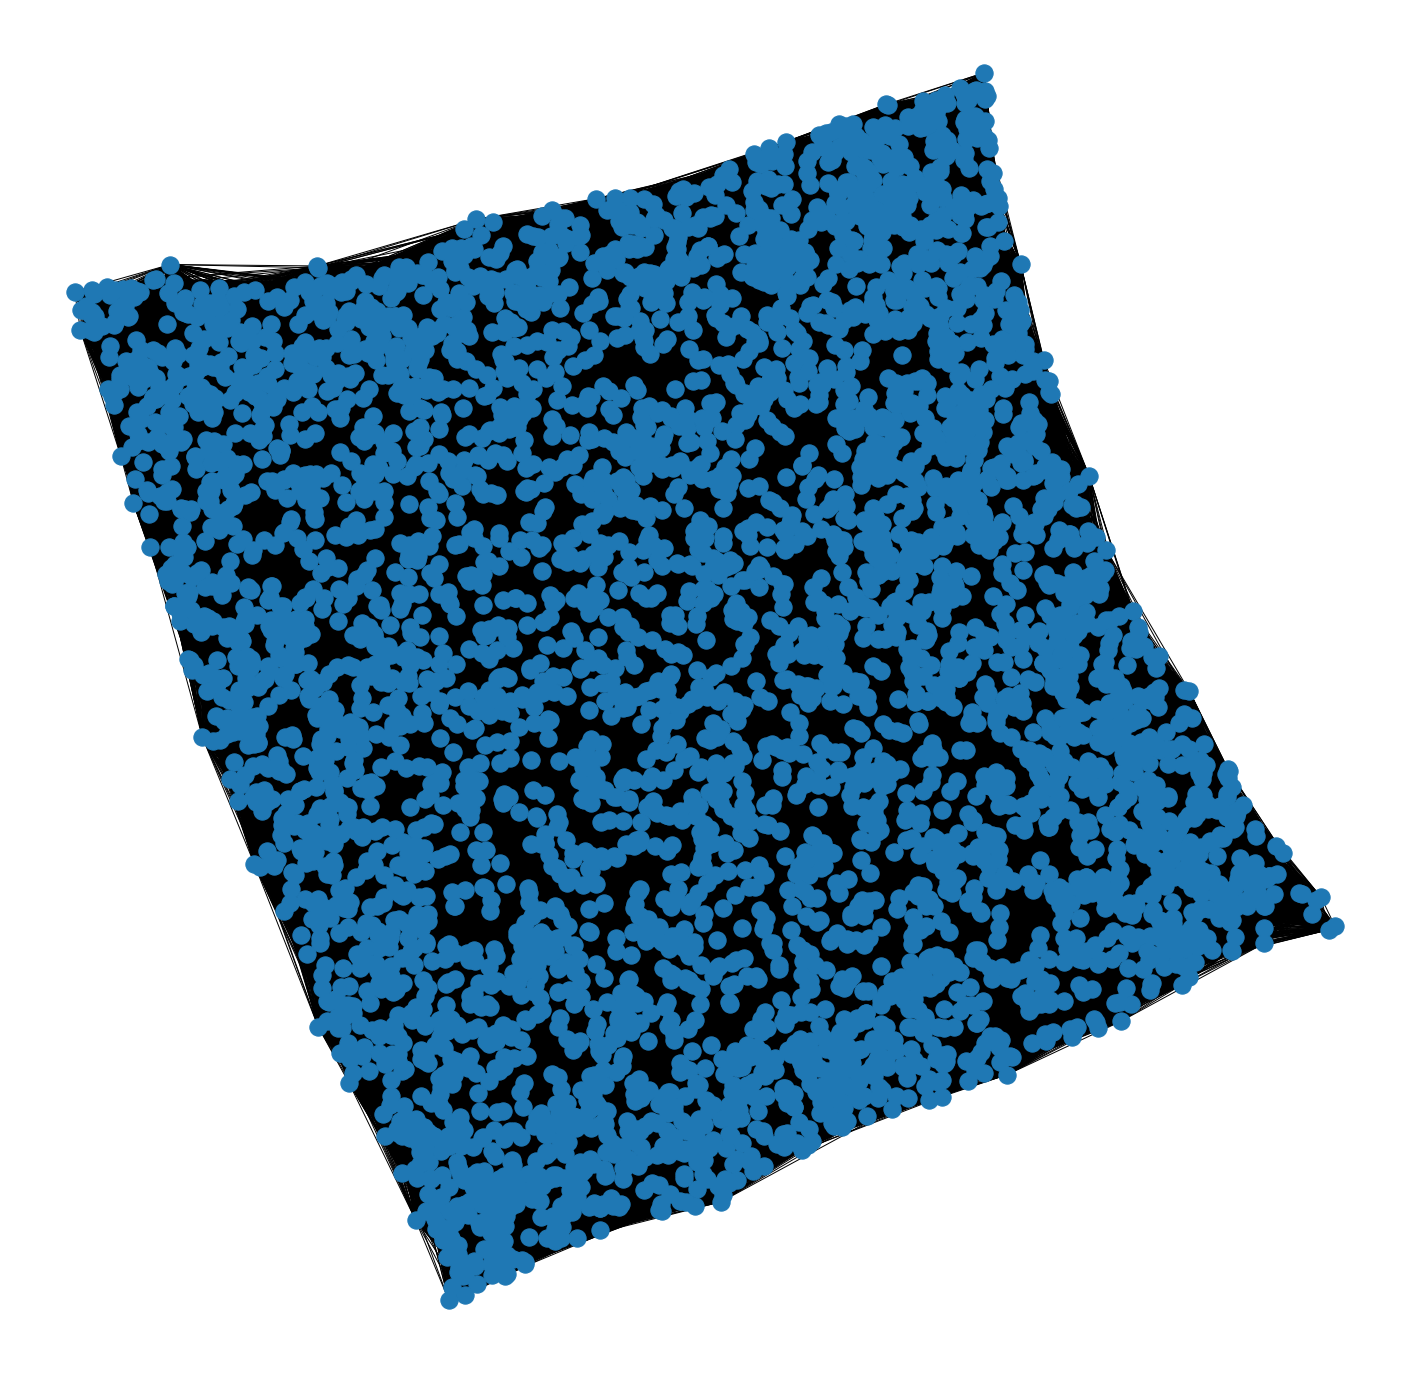

In [37]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

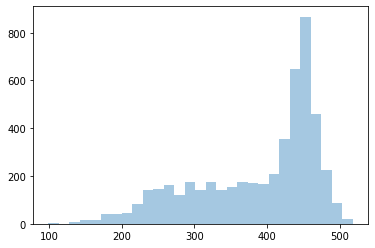

In [38]:
sns.distplot(list(dict(G.degree()).values()), kde=False)

Notes
-----
- This uses a *k*-d tree to build the graph.

- The `pos` keyword argument can be used to specify node positions so you can create an arbitrary distribution and domain for positions.

- For example, to use a 2D Gaussian distribution of node positions with mean (0, 0) and standard deviation 2

- The scipy.stats package can be used to define the probability distribution with the .pdf method used as `p_dist`.

In [39]:
@py_random_state(6)
@nodes_or_number(0)
def soft_random_geometric_graph(n, radius, dim=2, pos=None, p=2, p_dist=None,
                                seed=None):
    r"""Returns a soft random geometric graph in the unit cube.

    The soft random geometric graph [1] model places `n` nodes uniformly at
    random in the unit cube in dimension `dim`. Two nodes of distance, `dist`,
    computed by the `p`-Minkowski distance metric are joined by an edge with
    probability `p_dist` if the computed distance metric value of the nodes
    is at most `radius`, otherwise they are not joined.

    Edges within `radius` of each other are determined using a KDTree when
    SciPy is available. This reduces the time complexity from :math:`O(n^2)`
    to :math:`O(n)`.

    Parameters
    ----------
    n : int or iterable
        Number of nodes or iterable of nodes
    radius: float
        Distance threshold value
    dim : int, optional
        Dimension of graph
    pos : dict, optional
        A dictionary keyed by node with node positions as values.
    p : float, optional
        Which Minkowski distance metric to use.
        `p` has to meet the condition ``1 <= p <= infinity``.

        If this argument is not specified, the :math:`L^2` metric
        (the Euclidean distance metric), p = 2 is used.

        This should not be confused with the `p` of an Erdős-Rényi random
        graph, which represents probability.
    p_dist : function, optional
        A probability density function computing the probability of
        connecting two nodes that are of distance, dist, computed by the
        Minkowski distance metric. The probability density function, `p_dist`,
        must be any function that takes the metric value as input
        and outputs a single probability value between 0-1. The scipy.stats
        package has many probability distribution functions implemented and
        tools for custom probability distribution definitions [2], and passing
        the .pdf method of scipy.stats distributions can be used here.  If the
        probability function, `p_dist`, is not supplied, the default function
        is an exponential distribution with rate parameter :math:`\lambda=1`.
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    Graph
        A soft random geometric graph, undirected and without self-loops.
        Each node has a node attribute ``'pos'`` that stores the
        position of that node in Euclidean space as provided by the
        ``pos`` keyword argument or, if ``pos`` was not provided, as
        generated by this function.

    Examples
    --------
    Default Graph:

    G = nx.soft_random_geometric_graph(50, 0.2)

    Custom Graph:

    Create a soft random geometric graph on 100 uniformly distributed nodes
    where nodes are joined by an edge with probability computed from an
    exponential distribution with rate parameter :math:`\lambda=1` if their
    Euclidean distance is at most 0.2.

    Notes
    -----
    This uses a *k*-d tree to build the graph.

    The `pos` keyword argument can be used to specify node positions so you
    can create an arbitrary distribution and domain for positions.

    For example, to use a 2D Gaussian distribution of node positions with mean
    (0, 0) and standard deviation 2

    The scipy.stats package can be used to define the probability distribution
    with the .pdf method used as `p_dist`.

    ::

    >>> import random
    >>> import math
    >>> n = 100
    >>> pos = {i: (random.gauss(0, 2), random.gauss(0, 2)) for i in range(n)}
    >>> p_dist = lambda dist : math.exp(-dist)
    >>> G = nx.soft_random_geometric_graph(n, 0.2, pos=pos, p_dist=p_dist)

    References
    ----------
    .. [1] Penrose, Mathew D. "Connectivity of soft random geometric graphs."
           The Annals of Applied Probability 26.2 (2016): 986-1028.
       [2] scipy.stats -
           https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

    """
    n_name, nodes = n
    G = nx.Graph()
    G.name = 'soft_random_geometric_graph({}, {}, {})'.format(n, radius, dim)
    G.add_nodes_from(nodes)
    # If no positions are provided, choose uniformly random vectors in
    # Euclidean space of the specified dimension.
    if pos is None:
        pos = {v: [seed.random() for i in range(dim)] for v in nodes}
    nx.set_node_attributes(G, pos, 'pos')

    # if p_dist function not supplied the default function is an exponential
    # distribution with rate parameter :math:`\lambda=1`.
    if p_dist is None:

        def p_dist(dist):
            return math.exp(-dist)

    def should_join(pair):
        u, v = pair
        u_pos, v_pos = pos[u], pos[v]
        dist = (sum(abs(a - b) ** p for a, b in zip(u_pos, v_pos)))**(1 / p)
        # Check if dist <= radius parameter. This check is redundant if scipy
        # is available and _fast_edges routine is used, but provides the
        # check in case scipy is not available and all edge combinations
        # need to be checked
        if dist <= radius:
            return seed.random() < p_dist(dist)
        else:
            return False

    if _is_scipy_available:
        edges = _fast_edges(G, radius, p)
        G.add_edges_from(filter(should_join, edges))
    else:
        G.add_edges_from(filter(should_join, combinations(G, 2)))

    return G

In [40]:
n = 6000
pos = {i: (random.gauss(0, 5), random.gauss(0, 5)) for i in range(n)}
p_dist = lambda dist : math.exp(-dist)

G = nx.soft_random_geometric_graph(n, .4261, pos=pos, p_dist=p_dist)
cc = max(nx.connected_components(G), key=len)
G.remove_nodes_from(set(G)-cc)

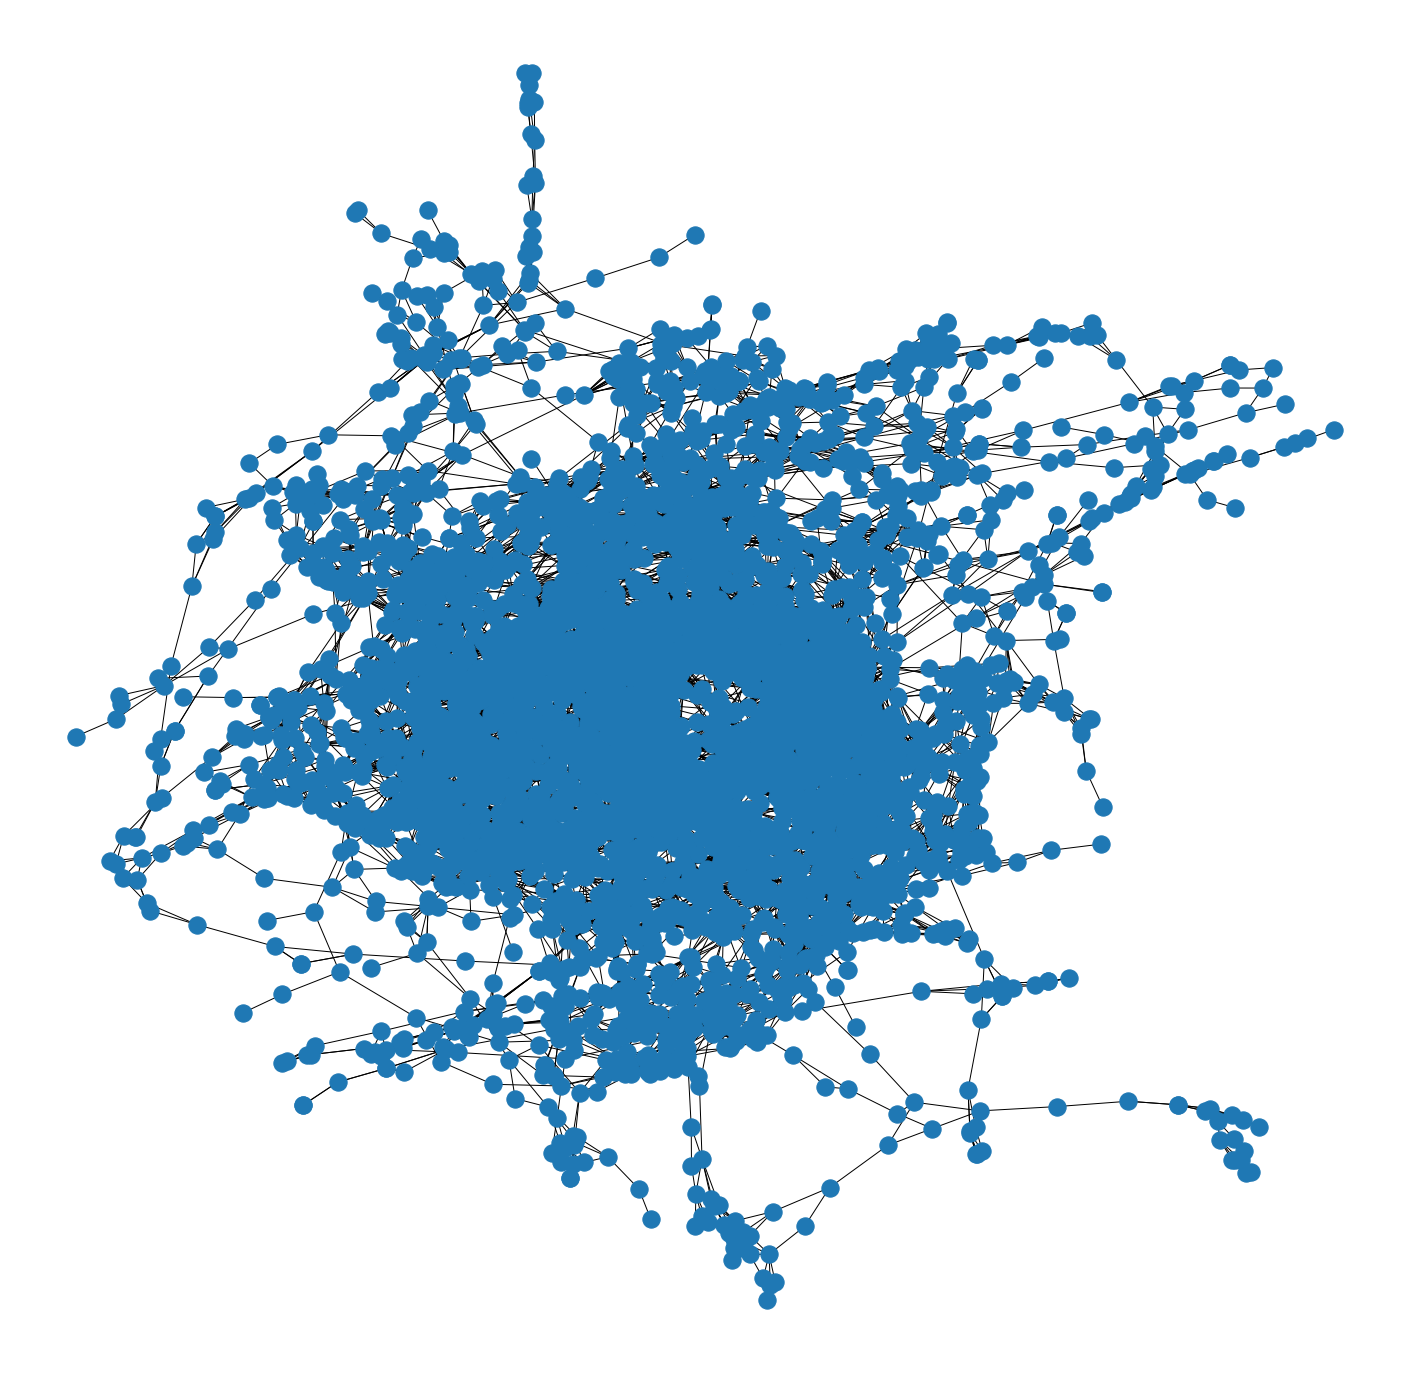

In [44]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

In [42]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 4917
 EDGES:  24221
 Coeficiente de agrupamiento:  0.4687651927263327
 Distancia media:  22.035
 Desviación estandar:  10.808042144625455


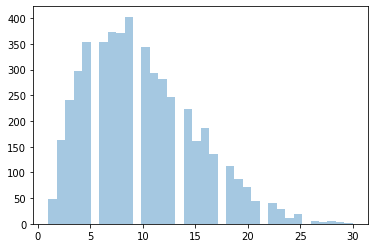

In [60]:
sns.distplot(list(dict(G.degree()).values()), kde=False)

# Stochastic block model

In [47]:
?nx.stochastic_block_model

Signature:
nx.stochastic_block_model(
    sizes,
    p,
    nodelist=None,
    seed=None,
    directed=False,
    selfloops=False,
    sparse=True,
)
Docstring:
Returns a stochastic block model graph.

This model partitions the nodes in blocks of arbitrary sizes, and places
edges between pairs of nodes independently, with a probability that depends
on the blocks.

Parameters
----------
sizes : list of ints
    Sizes of blocks
p : list of list of floats
    Element (r,s) gives the density of edges going from the nodes
    of group r to nodes of group s.
    p must match the number of groups (len(sizes) == len(p)),
    and it must be symmetric if the graph is undirected.
nodelist : list, optional
    The block tags are assigned according to the node identifiers
    in nodelist. If nodelist is None, then the ordering is the
    range [0,sum(sizes)-1].
seed : integer, random_state, or None (default)
    Indicator of random number generation state.
    See :ref:`Randomness<randomness>`.
dir

In [48]:
@py_random_state(3)
def stochastic_block_model(sizes, p, nodelist=None, seed=None,
                           directed=False, selfloops=False, sparse=True):
    """Returns a stochastic block model graph.

    This model partitions the nodes in blocks of arbitrary sizes, and places
    edges between pairs of nodes independently, with a probability that depends
    on the blocks.

    Parameters
    ----------
    sizes : list of ints
        Sizes of blocks
    p : list of list of floats
        Element (r,s) gives the density of edges going from the nodes
        of group r to nodes of group s.
        p must match the number of groups (len(sizes) == len(p)),
        and it must be symmetric if the graph is undirected.
    nodelist : list, optional
        The block tags are assigned according to the node identifiers
        in nodelist. If nodelist is None, then the ordering is the
        range [0,sum(sizes)-1].
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    directed : boolean optional, default=False
        Whether to create a directed graph or not.
    selfloops : boolean optional, default=False
        Whether to include self-loops or not.
    sparse: boolean optional, default=True
        Use the sparse heuristic to speed up the generator.

    Returns
    -------
    g : NetworkX Graph or DiGraph
        Stochastic block model graph of size sum(sizes)

    Raises
    ------
    NetworkXError
      If probabilities are not in [0,1].
      If the probability matrix is not square (directed case).
      If the probability matrix is not symmetric (undirected case).
      If the sizes list does not match nodelist or the probability matrix.
      If nodelist contains duplicate.

    Examples
    --------
    >>> sizes = [75, 75, 300]
    >>> probs = [[0.25, 0.05, 0.02],
    ...          [0.05, 0.35, 0.07],
    ...          [0.02, 0.07, 0.40]]
    >>> g = nx.stochastic_block_model(sizes, probs, seed=0)
    >>> len(g)
    450
    >>> H = nx.quotient_graph(g, g.graph['partition'], relabel=True)
    >>> for v in H.nodes(data=True):
    ...     print(round(v[1]['density'], 3))
    ...
    0.245
    0.348
    0.405
    >>> for v in H.edges(data=True):
    ...     print(round(1.0 * v[2]['weight'] / (sizes[v[0]] * sizes[v[1]]), 3))
    ...
    0.051
    0.022
    0.07

    See Also
    --------
    random_partition_graph
    planted_partition_graph
    gaussian_random_partition_graph
    gnp_random_graph

    References
    ----------
    .. [1] Holland, P. W., Laskey, K. B., & Leinhardt, S.,
           "Stochastic blockmodels: First steps",
           Social networks, 5(2), 109-137, 1983.
    """
    # Check if dimensions match
    if len(sizes) != len(p):
        raise nx.NetworkXException("'sizes' and 'p' do not match.")
    # Check for probability symmetry (undirected) and shape (directed)
    for row in p:
        if len(p) != len(row):
            raise nx.NetworkXException("'p' must be a square matrix.")
    if not directed:
        p_transpose = [list(i) for i in zip(*p)]
        for i in zip(p, p_transpose):
            for j in zip(i[0], i[1]):
                if abs(j[0] - j[1]) > 1e-08:
                    raise nx.NetworkXException("'p' must be symmetric.")
    # Check for probability range
    for row in p:
        for prob in row:
            if prob < 0 or prob > 1:
                raise nx.NetworkXException("Entries of 'p' not in [0,1].")
    # Check for nodelist consistency
    if nodelist is not None:
        if len(nodelist) != sum(sizes):
            raise nx.NetworkXException("'nodelist' and 'sizes' do not match.")
        if len(nodelist) != len(set(nodelist)):
            raise nx.NetworkXException("nodelist contains duplicate.")
    else:
        nodelist = range(0, sum(sizes))

    # Setup the graph conditionally to the directed switch.
    block_range = range(len(sizes))
    if directed:
        g = nx.DiGraph()
        block_iter = itertools.product(block_range, block_range)
    else:
        g = nx.Graph()
        block_iter = itertools.combinations_with_replacement(block_range, 2)
    # Split nodelist in a partition (list of sets).
    size_cumsum = [sum(sizes[0:x]) for x in range(0, len(sizes) + 1)]
    g.graph['partition'] = [set(nodelist[size_cumsum[x]:size_cumsum[x + 1]])
                            for x in range(0, len(size_cumsum) - 1)]
    # Setup nodes and graph name
    for block_id, nodes in enumerate(g.graph['partition']):
        for node in nodes:
            g.add_node(node, block=block_id)

    g.name = "stochastic_block_model"

    # Test for edge existence
    parts = g.graph['partition']
    for i, j in block_iter:
        if i == j:
            if directed:
                if selfloops:
                    edges = itertools.product(parts[i], parts[i])
                else:
                    edges = itertools.permutations(parts[i], 2)
            else:
                edges = itertools.combinations(parts[i], 2)
                if selfloops:
                    edges = itertools.chain(edges, zip(parts[i], parts[i]))
            for e in edges:
                if seed.random() < p[i][j]:
                    g.add_edge(*e)
        else:
            edges = itertools.product(parts[i], parts[j])
        if sparse:
            if p[i][j] == 1:  # Test edges cases p_ij = 0 or 1
                for e in edges:
                    g.add_edge(*e)
            elif p[i][j] > 0:
                while True:
                    try:
                        logrand = math.log(seed.random())
                        skip = math.floor(logrand / math.log(1 - p[i][j]))
                        # consume "skip" edges
                        next(itertools.islice(edges, skip, skip), None)
                        e = next(edges)
                        g.add_edge(*e)  # __safe
                    except StopIteration:
                        break
        else:
            for e in edges:
                if seed.random() < p[i][j]:
                    g.add_edge(*e)  # __safe
    return g

In [57]:
sizes = [1750, 1750, 1300]
probs = [[0.25, 0.05, 0.02],
        [0.05, 0.35, 0.07],
        [0.02, 0.07, 0.40]]
g = nx.stochastic_block_model(sizes, probs, seed=0)

H = nx.quotient_graph(g, g.graph['partition'], relabel=True)
for v in H.nodes(data=True):
    print(round(v[1]['density'], 3))
    for v in H.edges(data=True):
        print(round(1.0 * v[2]['weight'] / (sizes[v[0]] * sizes[v[1]]), 3))

0.25
0.05
0.02
0.07
0.349
0.05
0.02
0.07
0.4
0.05
0.02
0.07


In [58]:
cc = max(nx.connected_components(G), key=len)
G.remove_nodes_from(set(H)-cc)

In [59]:
print(" NODOS :",len(g.nodes()))
print(" EDGES: ",len(g.edges()))
print(" Coeficiente de agrupamiento: ", nx.average_clustering(g))

dist_media, stdev = estimar_distancia_media(g)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOS : 4800
 EDGES:  1612835
 Coeficiente de agrupamiento:  0.22685822740742856
 Distancia media:  1.85
 Desviación estandar:  0.3570714214271425


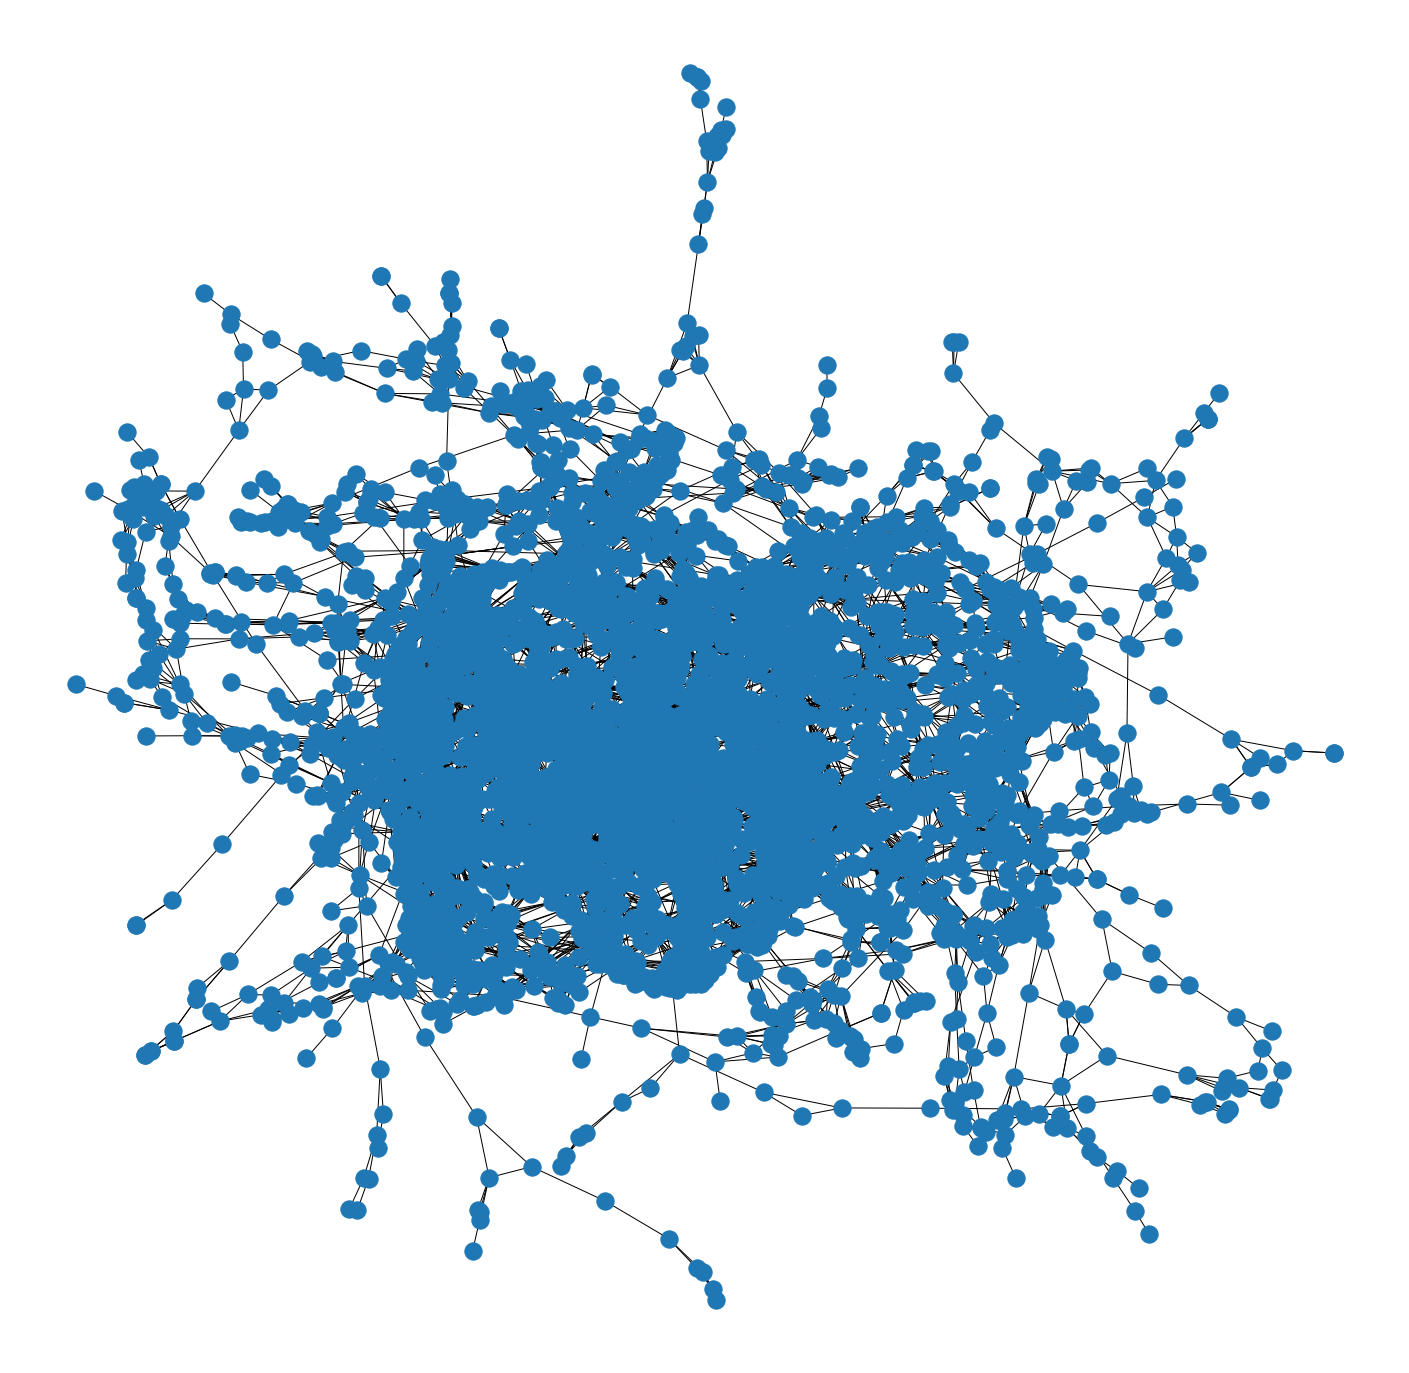

In [61]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

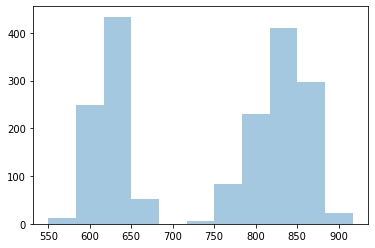

In [49]:
sns.distplot(list(dict(g.degree()).values()), kde=False)

In [63]:
?nx.stochastic_block_model

Signature:
nx.stochastic_block_model(
    sizes,
    p,
    nodelist=None,
    seed=None,
    directed=False,
    selfloops=False,
    sparse=True,
)
Docstring:
Returns a stochastic block model graph.

This model partitions the nodes in blocks of arbitrary sizes, and places
edges between pairs of nodes independently, with a probability that depends
on the blocks.

Parameters
----------
sizes : list of ints
    Sizes of blocks
p : list of list of floats
    Element (r,s) gives the density of edges going from the nodes
    of group r to nodes of group s.
    p must match the number of groups (len(sizes) == len(p)),
    and it must be symmetric if the graph is undirected.
nodelist : list, optional
    The block tags are assigned according to the node identifiers
    in nodelist. If nodelist is None, then the ordering is the
    range [0,sum(sizes)-1].
seed : integer, random_state, or None (default)
    Indicator of random number generation state.
    See :ref:`Randomness<randomness>`.
dir

# Relaxed_caveman_graph

In [50]:
?nx.relaxed_caveman_graph

Signature: nx.relaxed_caveman_graph(l, k, p, seed=None)
Docstring:
Returns a relaxed caveman graph.

A relaxed caveman graph starts with `l` cliques of size `k`.  Edges are
then randomly rewired with probability `p` to link different cliques.

Parameters
----------
l : int
  Number of groups
k : int
  Size of cliques
p : float
  Probabilty of rewiring each edge.
seed : integer, random_state, or None (default)
    Indicator of random number generation state.
    See :ref:`Randomness<randomness>`.

Returns
-------
G : NetworkX Graph
  Relaxed Caveman Graph

Raises
------
NetworkXError:
 If p is not in [0,1]

Examples
--------
>>> G = nx.relaxed_caveman_graph(2, 3, 0.1, seed=42)

References
----------
.. [1] Santo Fortunato, Community Detection in Graphs,
   Physics Reports Volume 486, Issues 3-5, February 2010, Pages 75-174.
   https://arxiv.org/abs/0906.0612
File:      ~/anaconda3/lib/python3.7/site-packages/networkx/generators/community.py
Type:      function


In [51]:
def caveman_graph(l, k):
    """Returns a caveman graph of `l` cliques of size `k`.

    Parameters
    ----------
    l : int
      Number of cliques
    k : int
      Size of cliques

    Returns
    -------
    G : NetworkX Graph
      caveman graph

    Notes
    -----
    This returns an undirected graph, it can be converted to a directed
    graph using :func:`nx.to_directed`, or a multigraph using
    ``nx.MultiGraph(nx.caveman_graph(l, k))``. Only the undirected version is
    described in [1]_ and it is unclear which of the directed
    generalizations is most useful.

    Examples
    --------
    >>> G = nx.caveman_graph(3, 3)

    See also
    --------

    connected_caveman_graph

    References
    ----------
    .. [1] Watts, D. J. 'Networks, Dynamics, and the Small-World Phenomenon.'
       Amer. J. Soc. 105, 493-527, 1999.
    """
    # l disjoint cliques of size k
    G = nx.empty_graph(l * k)
    if k > 1:
        for start in range(0, l * k, k):
            edges = itertools.combinations(range(start, start + k), 2)
            G.add_edges_from(edges)
    return G

@py_random_state(3)
def relaxed_caveman_graph(l, k, p, seed=None):
    """Returns a relaxed caveman graph.

    A relaxed caveman graph starts with `l` cliques of size `k`.  Edges are
    then randomly rewired with probability `p` to link different cliques.

    Parameters
    ----------
    l : int
      Number of groups
    k : int
      Size of cliques
    p : float
      Probabilty of rewiring each edge.
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : NetworkX Graph
      Relaxed Caveman Graph

    Raises
    ------
    NetworkXError:
     If p is not in [0,1]

    Examples
    --------
    >>> G = nx.relaxed_caveman_graph(2, 3, 0.1, seed=42)

    References
    ----------
    .. [1] Santo Fortunato, Community Detection in Graphs,
       Physics Reports Volume 486, Issues 3-5, February 2010, Pages 75-174.
       https://arxiv.org/abs/0906.0612
    """
    G = nx.caveman_graph(l, k)
    nodes = list(G)
    for (u, v) in G.edges():
        if seed.random() < p:  # rewire the edge
            x = seed.choice(nodes)
            if G.has_edge(u, x):
                continue
            G.remove_edge(u, v)
            G.add_edge(u, x)
    return G

In [52]:
G = nx.relaxed_caveman_graph(500, 10,.2)

In [53]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 5000
 EDGES:  22500
 Coeficiente de agrupamiento:  0.5543614130314116
 Distancia media:  5.475
 Desviación estandar:  0.9588404455382553


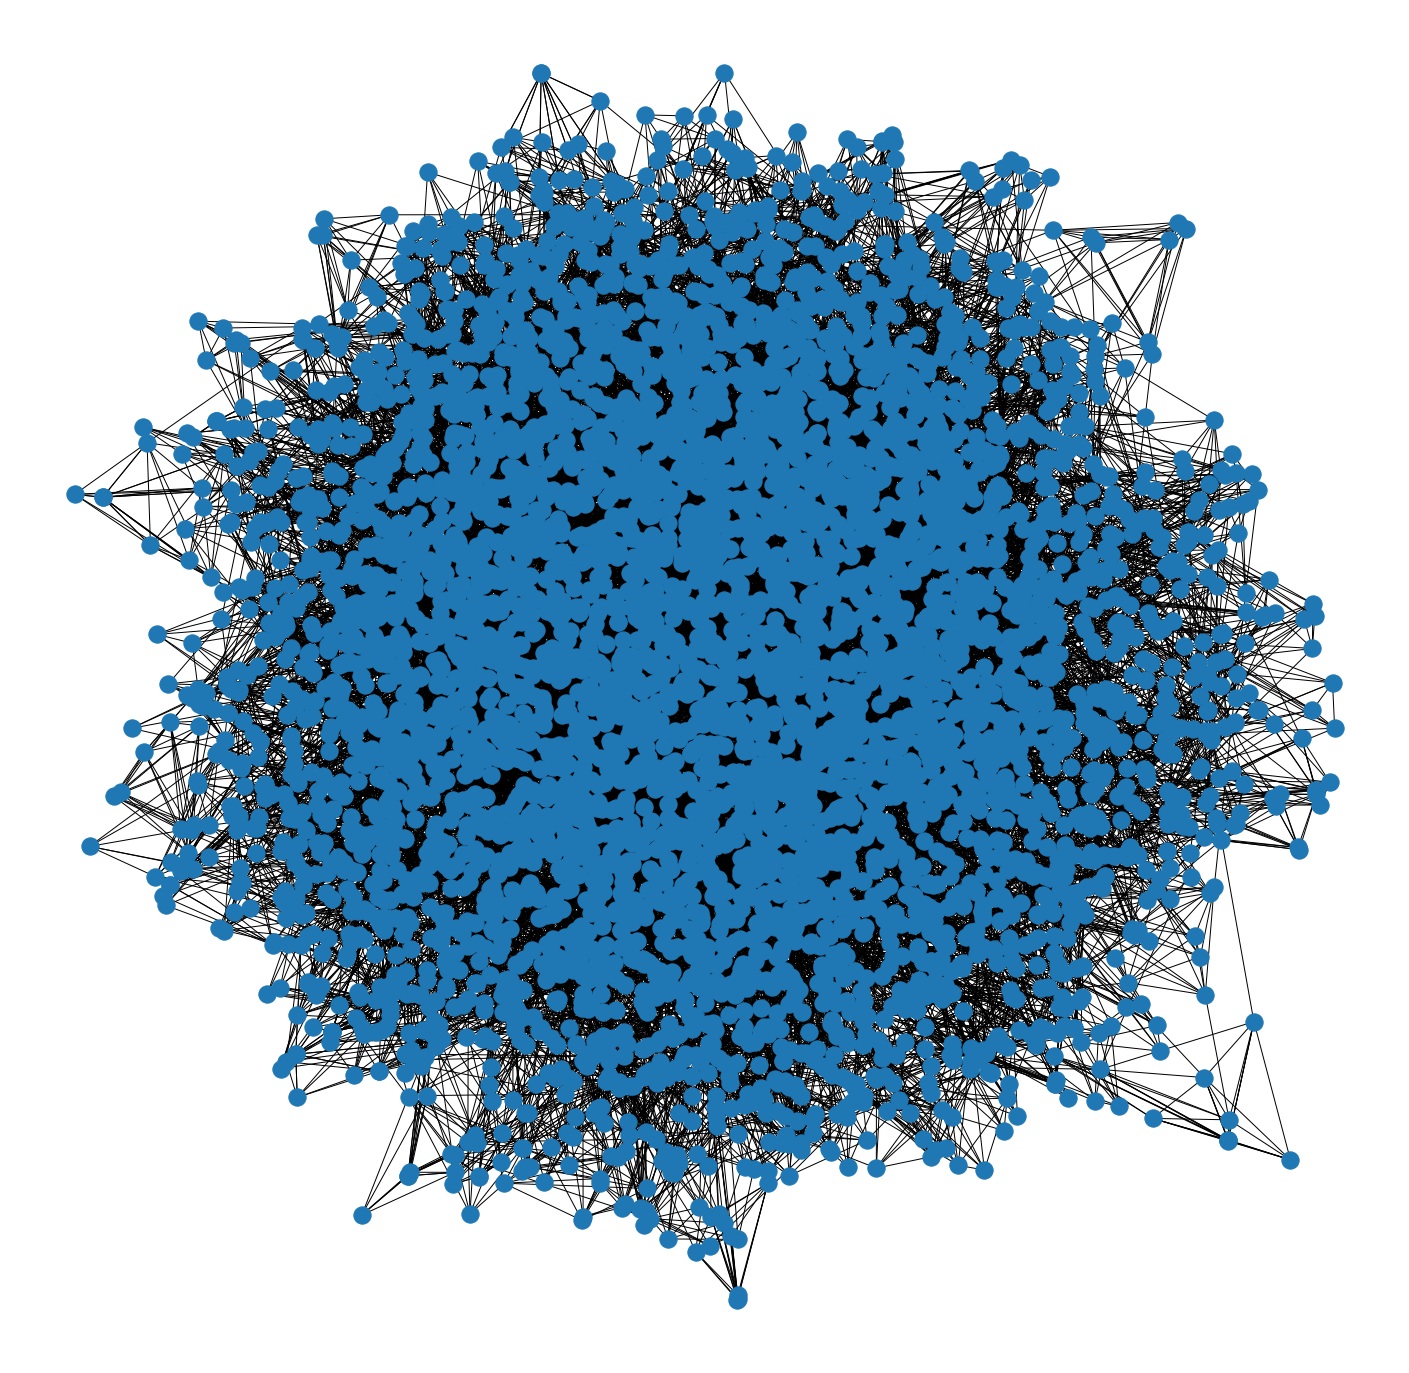

In [54]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

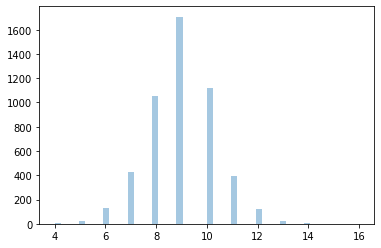

In [55]:
sns.distplot(list(dict(G.degree()).values()), kde=False)